In [ ]:
!pip show joblib
!pip show scikit-learn

Name: joblib
Version: 1.3.2
Summary: Lightweight pipelining with Python functions
Home-page: 
Author: 
Author-email: Gael Varoquaux <gael.varoquaux@normalesup.org>
License: BSD 3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: imbalanced-learn, librosa, mlxtend, music21, nltk, pins, scikit-learn
Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

aircon = pd.read_csv('/content/drive/MyDrive/Dummy_data_DATEUnified.csv')
aircon.shape

(690520, 21)

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
aircon = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/LG/Dummy_data_DATEUnified.csv')
aircon.shape

(690520, 21)

# 1) Data Preprocessing

## select only June, July, August, September

In [ ]:
aircon['DATE'] = pd.to_datetime(aircon['DATE'], format='%Y-%m-%d %H:%M')

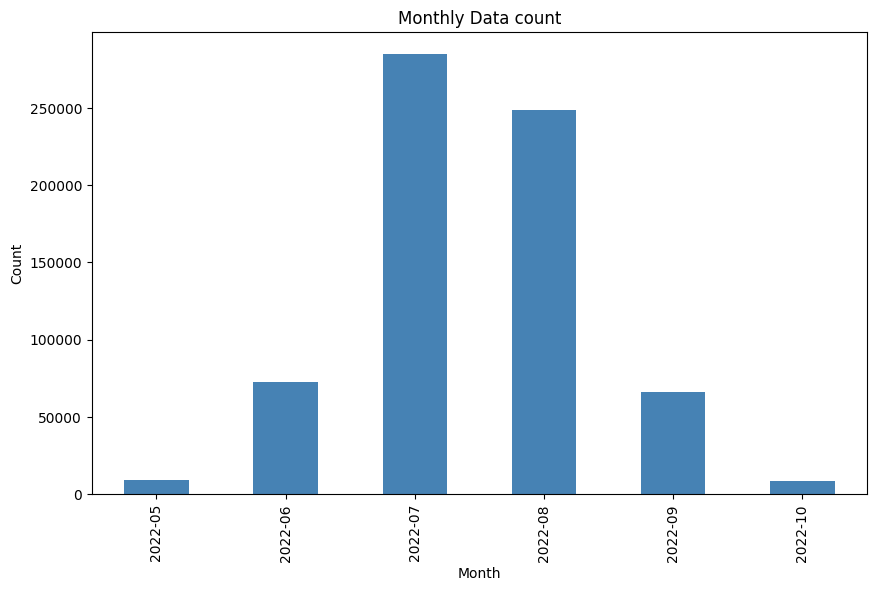

In [ ]:
import matplotlib.pyplot as plt

# 월별로 데이터 수를 계산합니다.
monthly_counts = aircon.groupby(aircon['DATE'].dt.to_period("M")).size()

# 그래프를 그립니다.
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='bar', color='steelblue')
plt.title('Monthly Data count')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 여러 개의 특정 월 선택 (예: 6,7,8,9월)
selected_months = [6,7,8,9]
aircon = aircon[aircon['DATE'].dt.month.isin(selected_months)]
print(aircon.shape)

(672866, 21)


## remove outliers from categorical variables

In [ ]:
from collections import Counter

def count_cols (dataframe, cols):
  for k in cols:
    print(k, ': ', sorted(Counter(dataframe[k]).items(), key=lambda pair: pair[1], reverse=True))

count_cols(aircon, ['A','B','C','D','O'])
print(aircon.shape)

A :  [('ON', 672864), ('OFF', 2)]
B :  [('C', 622392), ('D', 50362), ('F', 69), ('A', 43)]
C :  [('L', 236935), ('H', 127401), ('M', 105056), ('ML', 87632), ('A', 50372), ('MH', 35172), ('P', 30297), ('W', 1)]
D :  [('G', 435375), ('AR', 172408), ('N', 53477), ('B', 8088), ('VB', 3518)]
O :  [('C', 514629), ('S', 158237)]
(672866, 21)


In [ ]:
B_remove = ['F', 'A']

aircon = aircon[aircon['A'] != 'OFF']
aircon = aircon.drop(labels='A', axis=1)
aircon = aircon[~aircon['B'].isin(B_remove)]
aircon = aircon[aircon['C'] != 'W']

count_cols(aircon, ['B','C','D','O'])
print(aircon.shape)

B :  [('C', 622390), ('D', 50361)]
C :  [('L', 236891), ('H', 127383), ('M', 105032), ('ML', 87616), ('A', 50366), ('MH', 35166), ('P', 30297)]
D :  [('G', 435336), ('AR', 172337), ('N', 53474), ('B', 8087), ('VB', 3517)]
O :  [('C', 514617), ('S', 158134)]
(672751, 20)


## separate into continuous and categorical

In [ ]:
aircon_conti = aircon[['USER_SET_TEMPERATURE', 'CURRENT_ROOM_TEMPERATURE','p1','p2','p10','E','F','H','I','J','K','L','M','N']]
aircon_cate = aircon[['B','C','D','O']]

## remove outliers from continuous variables

In [ ]:
# Z-score 계산
z_scores = np.abs((aircon_conti - aircon_conti.mean()) / aircon_conti.std())

# 이상치를 선별할 Z-score 임계값 설정
threshold = 3

# 각 행에 대해 각 열의 Z-score가 임계값을 넘는지 확인
outliers_per_row = z_scores.apply(lambda row: any(row > threshold), axis=1)

# 이상치인 행 출력
outlier_rows = aircon_conti[outliers_per_row]

# 이상치인 행 출력
print("Rows with Outliers:")
print(outlier_rows)

Rows with Outliers:
        USER_SET_TEMPERATURE  CURRENT_ROOM_TEMPERATURE  p1  p2  p10   E    F  \
456                     25.0                      26.0  41  54   75  70  129   
593                     26.0                      27.0   4   4    4  49  109   
640                     26.0                      27.5  19  50   72  84  135   
1295                    21.0                      19.5  13  14   19  36  172   
1299                    21.0                      19.0   5   6    8  41  172   
...                      ...                       ...  ..  ..  ...  ..  ...   
690259                  26.0                      26.0   4   4    4  70  115   
690297                  26.0                      27.0  12  13   17  59  157   
690336                  18.0                      29.0   4   4    4  71  105   
690403                  25.0                      27.5   0   0    0  75  110   
690443                  26.0                      27.5   4   4    4  57  168   

          H    I   

## drop outliers, and remove G

In [ ]:
aircon = aircon.drop(outlier_rows.index)
aircon = aircon.drop(labels=['G'],axis=1)
print(aircon.shape)

(624752, 19)


## parse float USER_SET_TEMP into int

In [ ]:
aircon['USER_SET_TEMPERATURE'] = aircon['USER_SET_TEMPERATURE'].astype(int)

### Export to CSV

In [ ]:
aircon.to_csv('AIRCON_0125.csv', index=False)

## seperate into JUNE/JULY/AUG and SEPTEMBER

In [ ]:
aircon678 = aircon[aircon['DATE'].dt.month.isin([6,7,8])]
aircon9 = aircon[aircon['DATE'].dt.month.isin([9])]
print('aircon678:', aircon678.shape)
print('aircon9:', aircon9.shape)

aircon678: (563252, 19)
aircon9: (61500, 19)


##Drop DATE, One-hot Encoding

In [ ]:
aircon678 = aircon678.drop(labels=['DATE'], axis=1)
aircon9 = aircon9.drop(labels=['DATE'], axis=1)

aircon678 = pd.get_dummies(aircon678)
aircon9 = pd.get_dummies(aircon9)

print(aircon678.shape)
print(aircon9.shape)

(563252, 29)
(61500, 29)


In [ ]:
aircon678.columns

## Drop more outliers from Continuous Variables

In [ ]:
df66 = aircon678
df66 = df66[~((df66['I'] < 47.5) |(df66['I'] > 107.5))]
df66 = df66[~((df66['J'] < 69) |(df66['J'] > 133))]
df66 = df66[~((df66['K'] < -22.5) |(df66['K'] > 37.5))]
df66 = df66[~((df66['L'] > 6358.5) )]
df66 = df66[~((df66['M'] >2064.5))]

aircon678 = df66

### Export to CSV

In [ ]:
aircon678.to_csv('AIRCON_678_0130.csv', index=False)

In [ ]:
aircon9.to_csv('AIRCON_9_0130.csv', index=False)

## Standard Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

def scale(df):
  scale_to_include = df.drop(labels=['USER_SET_TEMPERATURE','CURRENT_ROOM_TEMPERATURE'],axis=1)
  scale_to_exclude = df[['CURRENT_ROOM_TEMPERATURE']]

  scaler = StandardScaler()
  df_scaled = scaler.fit_transform(scale_to_include)

  result = np.concatenate([scale_to_exclude, df_scaled],axis=1)
  return result;

y678 = aircon678['USER_SET_TEMPERATURE']
y9 = aircon9['USER_SET_TEMPERATURE']
aircon678 = scale(aircon678)
aircon9 = scale(aircon9)

In [ ]:
print(aircon678.shape)
print(aircon9.shape)

(443399, 28)
(61500, 28)


## SPLIT DATA - TRAIN/VALID/TEST

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(aircon678, y678, test_size=0.1, stratify = y678, random_state=42)
# x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify = y_temp, random_state=42)


# In addtion, We will use

# y9 => y_test
# aircon9 => x_test
x_test = aircon9
y_test = y9

# as additional test data.


#2) LASSO with KFoldCrossVal and Rand Search

In [ ]:
import time
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import numpy as np
from scipy.stats import uniform

# # Lasso 회귀모델
# lasso_model = Lasso()

# # 탐색할 하이퍼파라미터 공간 정의
# param_dist = {
#     'alpha': uniform(0.001, 1.0)
# }

# # Randomized Search 설정
# random_search = RandomizedSearchCV(lasso_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, scoring='neg_mean_squared_error', n_jobs=-1)

# # Randomized Search 수행
# random_search.fit(x_train, y_train)

# # 최적의 하이퍼파라미터 출력
# print("Best Hyperparameters:", random_search.best_params_)

# # 최적의 모델을 사용하여 검증 세트 예측
# y_valid_pred = random_search.predict(x_valid)

# # 평가 지표 계산
# r2 = r2_score(y_valid, y_valid_pred)
# mse = mean_squared_error(y_valid, y_valid_pred)
# mae = mean_absolute_error(y_valid, y_valid_pred)
# rmse = np.sqrt(mse)

# # 결과 출력
# print("\nValidation Set Metrics:")
# print(f"R2 Score: {r2}")
# print(f"MSE: {mse}")
# print(f"MAE: {mae}")
# print(f"RMSE: {rmse}")

# # K-Fold Cross Validation 설정
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # K-Fold Cross Validation 수행
# cv_r2_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='r2')
# cv_mse_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='neg_mean_squared_error')
# cv_mae_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# # 최고의 K-Fold Cross Validation 결과 출력
# print("\nK-Fold Cross Validation Metrics:")
# print(f"Mean R2 Score: {np.mean(cv_r2_scores)}")
# print(f"Mean MSE: {np.mean(-cv_mse_scores)}")
# print(f"Mean MAE: {np.mean(-cv_mae_scores)}")

# # 최적의 모델과 하이퍼파라미터로 모델 다시 훈련
# best_model = random_search.best_estimator_
# best_model.fit(x_train, y_train)

best_model = load('la_model_comp.joblib')

# 측정 시작
start_time = time.time()

# Test 세트 예측
y_test_pred_la = best_model.predict(x_test)

# 측정 종료
end_time = time.time()

# Test 세트 평가 지표 계산
test_r2 = r2_score(y_test, y_test_pred_la)
test_mse = mean_squared_error(y_test, y_test_pred_la)
test_mae = mean_absolute_error(y_test, y_test_pred_la)
test_rmse = np.sqrt(test_mse)

# 최종 결과 출력
print("\nTest Set Metrics: September")
print(f"R2 Score: {test_r2}")
print(f"MSE: {test_mse}")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")

# 수행 시간 (초) 계산
execution_time_seconds = end_time - start_time

# 수행 시간 (밀리초)으로 변환
execution_time_ms = execution_time_seconds * 1000

print(f"Predict Execution Time: {execution_time_ms:.4f} milliseconds")

Best Hyperparameters: {'alpha': 0.05908361216819946}

Validation Set Metrics:
R2 Score: 0.5576609079844376
MSE: 2.2176590269026337
MAE: 1.073708828858596
RMSE: 1.4891806562343717

K-Fold Cross Validation Metrics:
Mean R2 Score: 0.563315197438939
Mean MSE: 2.1892762587855144
Mean MAE: 1.0693945482745557

Test Set Metrics: September
R2 Score: 0.4953185660545457
MSE: 2.522002002513814
MAE: 1.1513350249359595
RMSE: 1.5880812329707237
Predict Execution Time: 8.5924 milliseconds


In [ ]:
from sklearn import svm
from sklearn import datasets
from joblib import dump, load

dump(best_model, 'la_model_comp.joblib', compress=True)

['la_model_comp.joblib']

## USER_SET_TEMP / CURRENT_ROOM_TEMP Visualization for LASSO

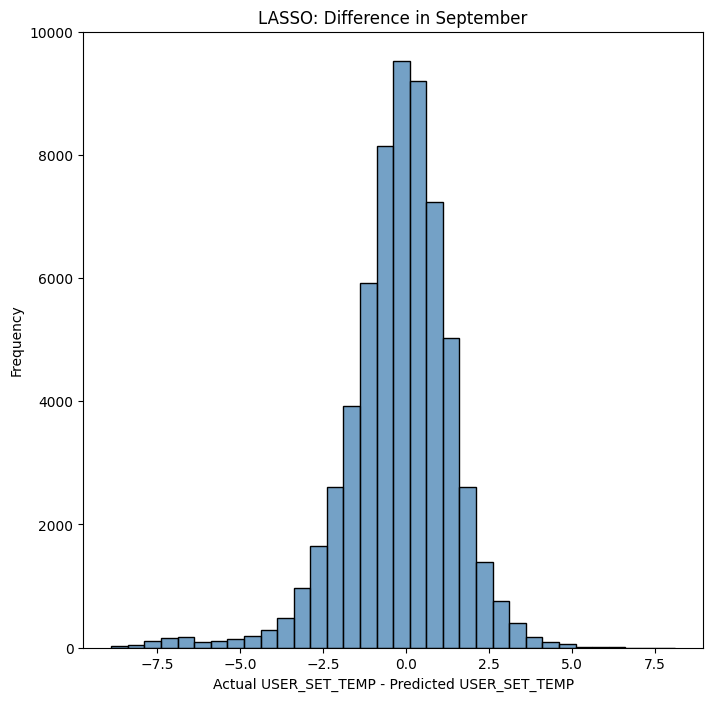

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def diff_graph(data, title):
  plt.figure(figsize=(8, 8))

  sns.histplot(x=data, binwidth=0.5, color='steelblue')

  # 그래프 제목 및 라벨 설정
  plt.title(title)
  plt.xlabel('Actual USER_SET_TEMP - Predicted USER_SET_TEMP')
  plt.ylabel('Frequency')

  # 그래프 표시
  plt.show()
diff = y_test - y_test_pred_la
diff_graph(diff, 'LASSO: Difference in September')

#3) DT with KFoldCrossVal and Rand Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import numpy as np
from scipy.stats import uniform
from scipy.stats import randint

# # Decision Tree 회귀모델
# tree_model = DecisionTreeRegressor()

# # 탐색할 하이퍼파라미터 공간 정의
# param_dist = {
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': randint(2, 20),
#     'min_samples_leaf': randint(1, 20),
#     'max_features': ['auto', 'sqrt', 'log2', None]
# }

# # Randomized Search 설정
# random_search = RandomizedSearchCV(tree_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, scoring='neg_mean_squared_error', n_jobs=-1)

# # Randomized Search 수행
# random_search.fit(x_train, y_train)

# # 최적의 하이퍼파라미터 출력
# print("Best Hyperparameters:", random_search.best_params_)

# # 최적의 모델을 사용하여 검증 세트 예측
# y_valid_pred = random_search.predict(x_valid)

# # 평가 지표 계산
# r2 = r2_score(y_valid, y_valid_pred)
# mse = mean_squared_error(y_valid, y_valid_pred)
# mae = mean_absolute_error(y_valid, y_valid_pred)
# rmse = np.sqrt(mse)

# # 결과 출력
# print("\nValidation Set Metrics:")
# print(f"R2 Score: {r2}")
# print(f"MSE: {mse}")
# print(f"MAE: {mae}")
# print(f"RMSE: {rmse}")

# # K-Fold Cross Validation 설정
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # K-Fold Cross Validation 수행
# cv_r2_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='r2')
# cv_mse_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='neg_mean_squared_error')
# cv_mae_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# # 최고의 K-Fold Cross Validation 결과 출력
# print("\nK-Fold Cross Validation Metrics:")
# print(f"Mean R2 Score: {np.mean(cv_r2_scores)}")
# print(f"Mean MSE: {np.mean(-cv_mse_scores)}")
# print(f"Mean MAE: {np.mean(-cv_mae_scores)}")

# # 최적의 모델과 하이퍼파라미터로 모델 다시 훈련
# best_model = random_search.best_estimator_
# best_model.fit(x_train, y_train)

best_model = load('dt_model_comp.joblib')

# 측정 시작
start_time = time.time()

# Test 세트 예측
y_test_pred_dt = best_model.predict(x_test)

# 측정 종료
end_time = time.time()

# Test 세트 평가 지표 계산
test_r2 = r2_score(y_test, y_test_pred_dt)
test_mse = mean_squared_error(y_test, y_test_pred_dt)
test_mae = mean_absolute_error(y_test, y_test_pred_dt)
test_rmse = np.sqrt(test_mse)

# 최종 결과 출력
print("\nTest Set Metrics: June, July and August")
print(f"R2 Score: {test_r2}")
print(f"MSE: {test_mse}")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")

# 수행 시간 (초) 계산
execution_time_seconds = end_time - start_time

# 수행 시간 (밀리초)으로 변환
execution_time_ms = execution_time_seconds * 1000

print(f"Predict Execution Time: {execution_time_ms:.4f} milliseconds")

Best Hyperparameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 12}

Validation Set Metrics:
R2 Score: 0.6029167941971922
MSE: 1.9907694609750928
MAE: 0.9746536466276857
RMSE: 1.4109462998197673

K-Fold Cross Validation Metrics:
Mean R2 Score: 0.5988067944646845
Mean MSE: 2.011652711259101
Mean MAE: 0.9797621322615347

Test Set Metrics: June, July and August
R2 Score: 0.47108291030431304
MSE: 2.6431128027595956
MAE: 1.1538018516339434
RMSE: 1.6257652975628418
Predict Execution Time: 17.6535 milliseconds


In [ ]:
from sklearn import svm
from sklearn import datasets
from joblib import dump, load

dump(best_model, 'dt_model_comp.joblib', compress=True)

['dt_model_comp.joblib']

## USER_SET_TEMP / CURRENT_ROOM_TEMP Visualization for DT

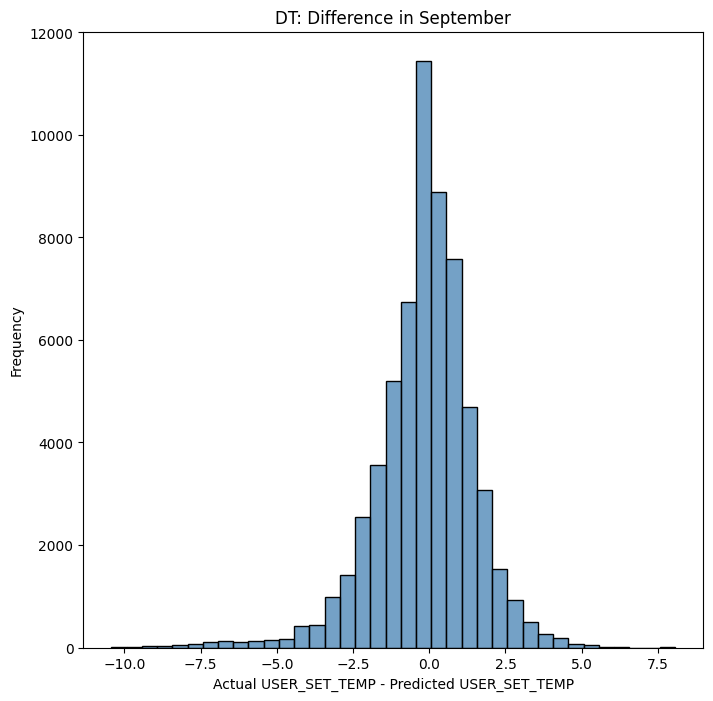

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def diff_graph(data, title):
  plt.figure(figsize=(8, 8))

  sns.histplot(x=data, binwidth=0.5, color='steelblue')

  # 그래프 제목 및 라벨 설정
  plt.title(title)
  plt.xlabel('Actual USER_SET_TEMP - Predicted USER_SET_TEMP')
  plt.ylabel('Frequency')

  # 그래프 표시
  plt.show()
diff = y_test - y_test_pred_dt
diff_graph(diff, 'DT: Difference in September')

#4) Random Forest with KFoldCrossVal and RandSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import numpy as np
from scipy.stats import uniform
from scipy.stats import randint
from joblib import load

# # Random Forest 회귀모델
# forest_model = RandomForestRegressor()

# # 탐색할 하이퍼파라미터 공간 정의
# param_dist = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': randint(2, 20),
#     'min_samples_leaf': randint(1, 20),
#     'max_features': ['auto', 'sqrt', 'log2', None]
# }

# # Randomized Search 설정
# random_search = RandomizedSearchCV(forest_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, scoring='neg_mean_squared_error', n_jobs=-1)

# # Randomized Search 수행
# random_search.fit(x_train, y_train)

# # 최적의 하이퍼파라미터 출력
# print("Best Hyperparameters:", random_search.best_params_)

# # 최적의 모델을 사용하여 검증 세트 예측
# y_valid_pred = random_search.predict(x_valid)

# # 평가 지표 계산
# r2 = r2_score(y_valid, y_valid_pred)
# mse = mean_squared_error(y_valid, y_valid_pred)
# mae = mean_absolute_error(y_valid, y_valid_pred)
# rmse = np.sqrt(mse)

# # 결과 출력
# print("\nValidation Set Metrics:")
# print(f"R2 Score: {r2}")
# print(f"MSE: {mse}")
# print(f"MAE: {mae}")
# print(f"RMSE: {rmse}")

# # K-Fold Cross Validation 설정
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # K-Fold Cross Validation 수행
# cv_r2_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='r2')
# cv_mse_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='neg_mean_squared_error')
# cv_mae_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# # 최고의 K-Fold Cross Validation 결과 출력
# print("\nK-Fold Cross Validation Metrics:")
# print(f"Mean R2 Score: {np.mean(cv_r2_scores)}")
# print(f"Mean MSE: {np.mean(-cv_mse_scores)}")
# print(f"Mean MAE: {np.mean(-cv_mae_scores)}")

# # 최적의 모델과 하이퍼파라미터로 모델 다시 훈련
# best_model = random_search.best_estimator_
# best_model.fit(x_train, y_train)

best_model = load('rf_model_comp.joblib')

# 측정 시작
start_time = time.time()

# Test 세트 예측
y_test_pred_rf = best_model.predict(x_test)

# 측정 종료
end_time = time.time()

# Test 세트 평가 지표 계산
test_r2 = r2_score(y_test, y_test_pred_rf)
test_mse = mean_squared_error(y_test, y_test_pred_rf)
test_mae = mean_absolute_error(y_test, y_test_pred_rf)
test_rmse = np.sqrt(test_mse)

# 최종 결과 출력
print("\nTest Set Metrics: September")
print(f"R2 Score: {test_r2}")
print(f"MSE: {test_mse}")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")

# 수행 시간 (초) 계산
execution_time_seconds = end_time - start_time

# 수행 시간 (밀리초)으로 변환
execution_time_ms = execution_time_seconds * 1000

print(f"Predict Execution Time: {execution_time_ms:.4f} milliseconds")


Test Set Metrics: September
R2 Score: 0.5484282192428147
MSE: 2.256601607958969
MAE: 1.052891115081337
RMSE: 1.5021989242303992
Predict Execution Time: 1484.3493 milliseconds


## Compress model

In [ ]:
from sklearn import svm
from sklearn import datasets
from joblib import dump, load

dump(best_model, 'rf_model_comp.joblib',compress=True)

## USER_SET_TEMP / CURRENT_ROOM_TEMP Visualization for RF

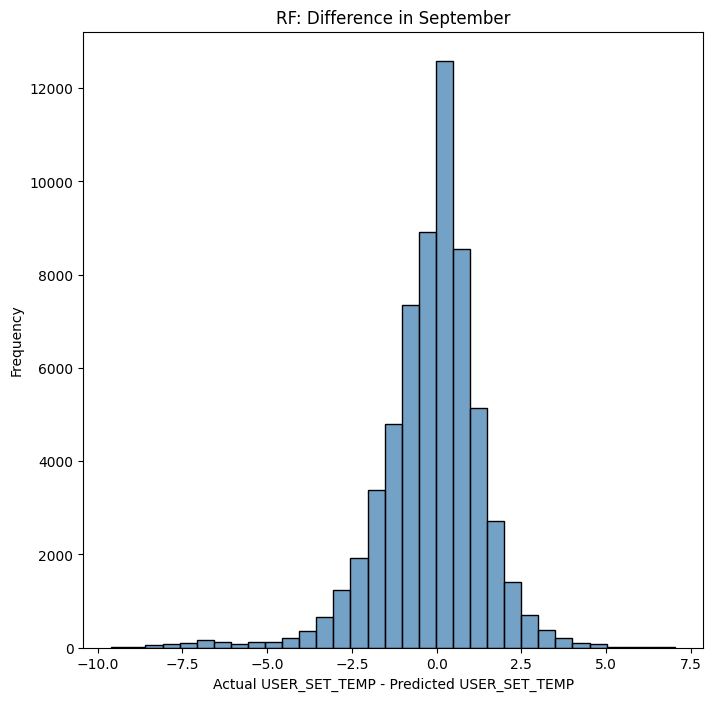

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def diff_graph(data, title):
  plt.figure(figsize=(8, 8))

  sns.histplot(x=data, binwidth=0.5, color='steelblue')

  # 그래프 제목 및 라벨 설정
  plt.title(title)
  plt.xlabel('Actual USER_SET_TEMP - Predicted USER_SET_TEMP')
  plt.ylabel('Frequency')

  # 그래프 표시
  plt.show()
diff = y_test - y_test_pred_rf
diff_graph(diff, 'RF: Difference in September')

# 5) Gradient Boosting with KFoldCrossVal and RandSearch

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, train_test_split
# from sklearn.ensemble import GradientBoostingRegressor  # 또는 GradientBoostingClassifier
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.utils import shuffle
# import numpy as np
# from scipy.stats import uniform
# from scipy.stats import randint

# # 데이터 로드 및 전처리
# # X_train, y_train: 훈련 데이터와 레이블
# # (이 예제에서는 데이터를 제공하지 않으므로 실제 데이터에 맞게 로드하고 전처리해야 합니다)

# # Gradient Boosting 모델 정의
# gb_model = GradientBoostingRegressor()  # 또는 GradientBoostingClassifier()

# # 하이퍼파라미터 탐색 공간 정의
# param_dist = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'max_depth': [3, 5, 7, 9],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # K-Fold Cross Validation을 위한 객체 생성
# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# # Randomized Search를 통한 하이퍼파라미터 튜닝
# random_search = RandomizedSearchCV(
#     gb_model,
#     param_distributions=param_dist,
#     n_iter=10,  # 적절한 반복 횟수 선택
#     scoring='neg_mean_squared_error',  # 평가 지표 선택
#     cv=k_fold,
#     n_jobs=-1,  # 모든 가능한 코어를 사용하여 병렬 처리
#     random_state=42
# )

# # Randomized Search 수행
# random_search.fit(x_train, y_train)

# # 최적의 하이퍼파라미터 출력
# print("Best Hyperparameters:", random_search.best_params_)

# # 최적의 모델을 사용하여 검증 세트 예측
# y_valid_pred = random_search.predict(x_valid)

# # 평가 지표 계산
# r2 = r2_score(y_valid, y_valid_pred)
# mse = mean_squared_error(y_valid, y_valid_pred)
# mae = mean_absolute_error(y_valid, y_valid_pred)
# rmse = np.sqrt(mse)

# # 결과 출력
# print("\nValidation Set Metrics:")
# print(f"R2 Score: {r2}")
# print(f"MSE: {mse}")
# print(f"MAE: {mae}")
# print(f"RMSE: {rmse}")

# # K-Fold Cross Validation 설정
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # K-Fold Cross Validation 수행
# cv_r2_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='r2')
# cv_mse_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='neg_mean_squared_error')
# cv_mae_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# # 최고의 K-Fold Cross Validation 결과 출력
# print("\nK-Fold Cross Validation Metrics:")
# print(f"Mean R2 Score: {np.mean(cv_r2_scores)}")
# print(f"Mean MSE: {np.mean(-cv_mse_scores)}")
# print(f"Mean MAE: {np.mean(-cv_mae_scores)}")

# # 최적의 모델과 하이퍼파라미터로 모델 다시 훈련
# best_model = random_search.best_estimator_
# best_model.fit(x_train, y_train)

best_model = load('gb_model_comp.joblib')

# 측정 시작
start_time = time.time()

# Test 세트 예측
y_test_pred_gb = best_model.predict(x_test)

# 측정 종료
end_time = time.time()

# Test 세트 평가 지표 계산
test_r2 = r2_score(y_test, y_test_pred_gb)
test_mse = mean_squared_error(y_test, y_test_pred_gb)
test_mae = mean_absolute_error(y_test, y_test_pred_gb)
test_rmse = np.sqrt(test_mse)

# 최종 결과 출력
print("\nTest Set Metrics: September")
print(f"R2 Score: {test_r2}")
print(f"MSE: {test_mse}")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")

# 수행 시간 (초) 계산
execution_time_seconds = end_time - start_time

# 수행 시간 (밀리초)으로 변환
execution_time_ms = execution_time_seconds * 1000

print(f"Predict Execution Time: {execution_time_ms:.4f} milliseconds")


Test Set Metrics: September
R2 Score: 0.525695745470381
MSE: 2.3702006835737994
MAE: 1.0788289068312373
RMSE: 1.5395456094490345
Predict Execution Time: 177.0430 milliseconds


In [ ]:
from sklearn import svm
from sklearn import datasets
from joblib import dump, load

dump(best_model, 'gb_model_comp.joblib',compress=True)

['gb_model_comp.joblib']

##Graph visualization for GB

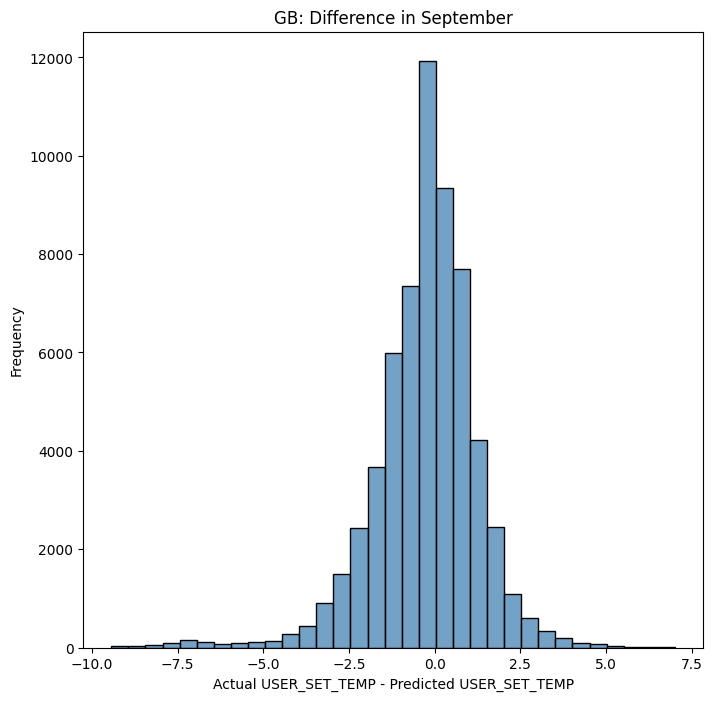

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def diff_graph(data, title):
  plt.figure(figsize=(8, 8))

  sns.histplot(x=data, binwidth=0.5, color='steelblue')

  # 그래프 제목 및 라벨 설정
  plt.title(title)
  plt.xlabel('Actual USER_SET_TEMP - Predicted USER_SET_TEMP')
  plt.ylabel('Frequency')

  # 그래프 표시
  plt.show()
diff = y_test - y_test_pred_gb
diff_graph(diff, 'GB: Difference in September')

# 6) ADABoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import numpy as np
from scipy.stats import uniform
from scipy.stats import randint

# # Adaboost 모델 정의
# adaboost_model = AdaBoostRegressor()

# # 하이퍼파라미터 탐색 공간 정의
# param_dist = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
# }

# # K-Fold Cross Validation을 위한 객체 생성
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Randomized Search를 통한 하이퍼파라미터 튜닝
# random_search = RandomizedSearchCV(
#     adaboost_model,
#     param_distributions=param_dist,
#     n_iter=10,
#     scoring='neg_mean_squared_error',
#     cv=kf,
#     random_state=42
# )

# # Randomized Search 수행
# random_search.fit(x_train, y_train)

# # 최적의 하이퍼파라미터 출력
# print("Best Hyperparameters:", random_search.best_params_)

# # 최적의 모델을 사용하여 검증 세트 예측
# y_valid_pred = random_search.predict(x_valid)

# # 평가 지표 계산
# r2 = r2_score(y_valid, y_valid_pred)
# mse = mean_squared_error(y_valid, y_valid_pred)
# mae = mean_absolute_error(y_valid, y_valid_pred)
# rmse = np.sqrt(mse)

# # 결과 출력
# print("\nValidation Set Metrics:")
# print(f"R2 Score: {r2}")
# print(f"MSE: {mse}")
# print(f"MAE: {mae}")
# print(f"RMSE: {rmse}")

# # K-Fold Cross Validation 설정
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # K-Fold Cross Validation 수행
# cv_r2_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='r2')
# cv_mse_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='neg_mean_squared_error')
# cv_mae_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# # 최고의 K-Fold Cross Validation 결과 출력
# print("\nK-Fold Cross Validation Metrics:")
# print(f"Mean R2 Score: {np.mean(cv_r2_scores)}")
# print(f"Mean MSE: {np.mean(-cv_mse_scores)}")
# print(f"Mean MAE: {np.mean(-cv_mae_scores)}")

# # 최적의 모델과 하이퍼파라미터로 모델 다시 훈련
# best_model = random_search.best_estimator_
# best_model.fit(x_train, y_train)

best_model = load('ada_model_comp.joblib')

# 측정 시작
start_time = time.time()

# Test 세트 예측
y_test_pred_ada = best_model.predict(x_test)

# 측정 종료
end_time = time.time()

# Test 세트 평가 지표 계산
test_r2 = r2_score(y_test, y_test_pred_ada)
test_mse = mean_squared_error(y_test, y_test_pred_ada)
test_mae = mean_absolute_error(y_test, y_test_pred_ada)
test_rmse = np.sqrt(test_mse)

# 최종 결과 출력
print("\nTest Set Metrics: September")
print(f"R2 Score: {test_r2}")
print(f"MSE: {test_mse}")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")

# 수행 시간 (초) 계산
execution_time_seconds = end_time - start_time

# 수행 시간 (밀리초)으로 변환
execution_time_ms = execution_time_seconds * 1000

print(f"Predict Execution Time: {execution_time_ms:.4f} milliseconds")


Test Set Metrics: September
R2 Score: 0.3693769847074063
MSE: 3.151359254422492
MAE: 1.2673472201176927
RMSE: 1.7752068201825082
Predict Execution Time: 1127.8555 milliseconds


In [ ]:
from sklearn import svm
from sklearn import datasets
from joblib import dump, load

dump(best_model, 'ada_model_comp.joblib',compress=True)

['ada_model_comp.joblib']

## graph visualization for ADA

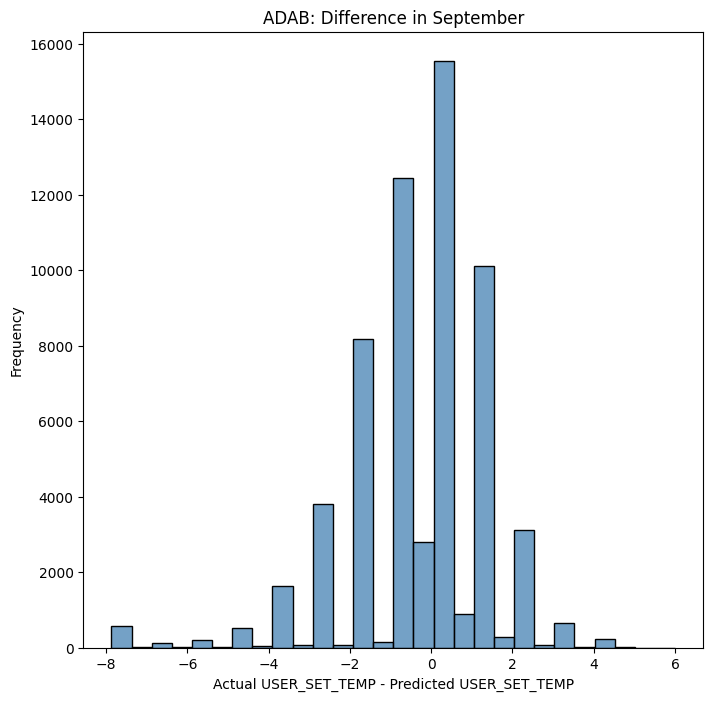

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def diff_graph(data, title):
  plt.figure(figsize=(8, 8))

  sns.histplot(x=data, binwidth=0.5, color='steelblue')

  # 그래프 제목 및 라벨 설정
  plt.title(title)
  plt.xlabel('Actual USER_SET_TEMP - Predicted USER_SET_TEMP')
  plt.ylabel('Frequency')

  # 그래프 표시
  plt.show()
diff = y_test - y_test_pred_ada
diff_graph(diff, 'ADAB: Difference in September')

# ~~~7) Polynomial Regression~~~

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import numpy as np
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.pipeline import make_pipeline

# Polynomial Regression 모델 정의
poly_model = LinearRegression()

# Polynomial 특징 생성
degree = 2  # 다항식의 차수 (적절한 값으로 설정)
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# 하이퍼파라미터 탐색 공간 정의 (Polynomial Regression에서는 하이퍼파라미터가 제한적이므로 생략 가능)
param_dist = {}

# K-Fold Cross Validation을 위한 객체 생성
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search를 통한 하이퍼파라미터 튜닝
random_search = RandomizedSearchCV(
    poly_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=kf,
    random_state=42
)

# Randomized Search 수행
random_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", random_search.best_params_)

# 최적의 모델을 사용하여 검증 세트 예측
y_valid_pred = random_search.predict(x_valid)

# 평가 지표 계산
r2 = r2_score(y_valid, y_valid_pred)
mse = mean_squared_error(y_valid, y_valid_pred)
mae = mean_absolute_error(y_valid, y_valid_pred)
rmse = np.sqrt(mse)

# 결과 출력
print("\nValidation Set Metrics:")
print(f"R2 Score: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# K-Fold Cross Validation 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# K-Fold Cross Validation 수행
cv_r2_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='r2')
cv_mse_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_mae_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# 최고의 K-Fold Cross Validation 결과 출력
print("\nK-Fold Cross Validation Metrics:")
print(f"Mean R2 Score: {np.mean(cv_r2_scores)}")
print(f"Mean MSE: {np.mean(-cv_mse_scores)}")
print(f"Mean MAE: {np.mean(-cv_mae_scores)}")

# 최적의 모델과 하이퍼파라미터로 모델 다시 훈련
best_model = random_search.best_estimator_
best_model.fit(x_train, y_train)

# Test 세트 예측
y_test_pred_pr = best_model.predict(x_test)

# Test 세트 평가 지표 계산
test_r2 = r2_score(y_test, y_test_pred_ada)
test_mse = mean_squared_error(y_test, y_test_pred_pr)
test_mae = mean_absolute_error(y_test, y_test_pred_pr)
test_rmse = np.sqrt(test_mse)

# 최종 결과 출력
print("\nTest Set Metrics: September")
print(f"R2 Score: {test_r2}")
print(f"MSE: {test_mse}")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {}

Validation Set Metrics:
R2 Score: 0.6232012726957756
MSE: 1.8890735953815234
MAE: 0.9738021876395797
RMSE: 1.3744357370868685

K-Fold Cross Validation Metrics:
Mean R2 Score: -3.3625289497701652e+16
Mean MSE: 1.6833676112818976e+17
Mean MAE: 824023.3079045451

Test Set Metrics: June, July and August
R2 Score: 0.3693769847074063
MSE: 1.5178582026191411e+19
MAE: 3569969089.9389277
RMSE: 3895969972.444784


In [ ]:
from sklearn import svm
from sklearn import datasets
from joblib import dump, load

dump(best_model, 'ada_model_comp.joblib',compress=True)

NameError: name 'best_model' is not defined

## Graph Visualization for PR

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def diff_graph(data, title):
  plt.figure(figsize=(8, 8))

  sns.histplot(x=data, binwidth=0.5, color='steelblue')

  # 그래프 제목 및 라벨 설정
  plt.title(title)
  plt.xlabel('Actual USER_SET_TEMP - Predicted USER_SET_TEMP')
  plt.ylabel('Frequency')

  # 그래프 표시
  plt.show()
diff = y_test - y_test_pred_pr
diff_graph(diff, 'PR: Difference in September')

NameError: name 'y_test' is not defined

# ~~~2) Feature Selection~~~

## 1. Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=0, max_depth=5)

## fitting a decision tree classifier
dt_result = tree_model.fit(x,y)

In [ ]:
import operator

## feature importances
d = dict(zip(x.columns,dt_result.feature_importances_))
d1 = sorted(d.items(), key=operator.itemgetter(1))
d2 = sorted(d.items(), key=lambda x: x[1], reverse=True)

for v in d2:
  print("{}".format(v))

('C_P', 0.741960416638798)
('K', 0.11456448520330856)
('CURRENT_ROOM_TEMPERATURE', 0.0822591571490373)
('L', 0.04453585154141864)
('C_L', 0.007398951617393514)
('E', 0.005276438029292339)
('C_H', 0.00394773599188378)
('M', 2.888487251801942e-05)
('J', 2.7969598485879395e-05)
('F', 1.0935786392372425e-07)
('p1', 0.0)
('p2', 0.0)
('p10', 0.0)
('G', 0.0)
('H', 0.0)
('I', 0.0)
('N', 0.0)
('B_C', 0.0)
('B_D', 0.0)
('C_A', 0.0)
('C_M', 0.0)
('C_MH', 0.0)
('C_ML', 0.0)
('D_AR', 0.0)
('D_B', 0.0)
('D_G', 0.0)
('D_N', 0.0)
('D_VB', 0.0)
('O_C', 0.0)
('O_S', 0.0)


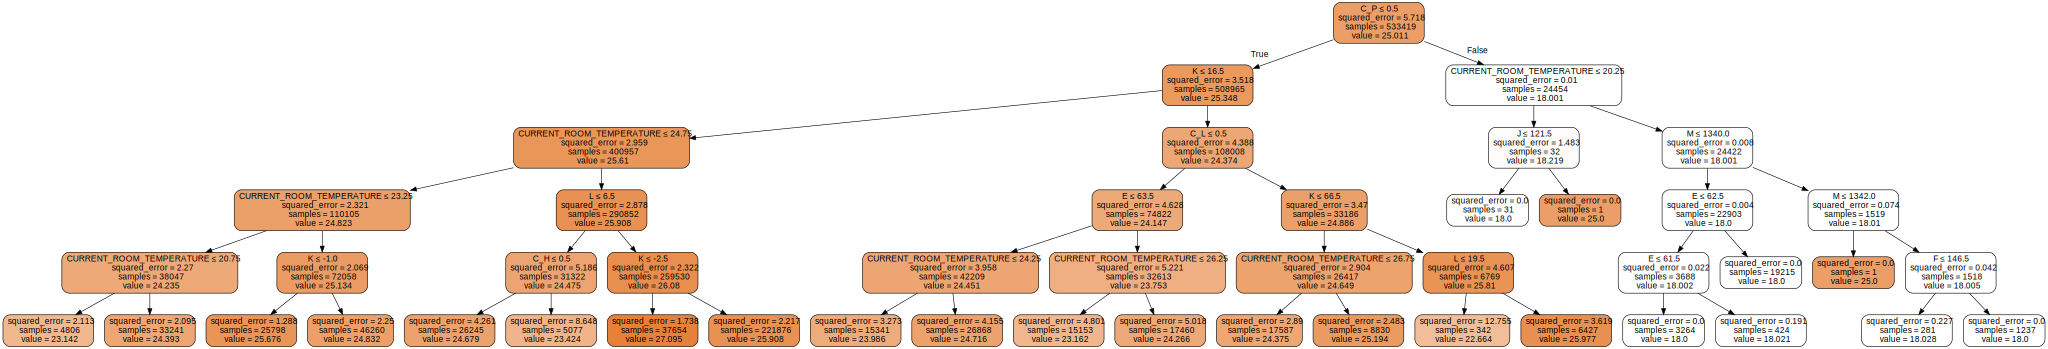

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

# 의사 결정 트리 시각화
dot_data = export_graphviz(tree_model, out_file=None,
                           feature_names=x.columns,
                           class_names=y.unique,
                           filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("decision tree", format='png', cleanup=True)

graph

In [ ]:
selected_features = x.columns[dt_result.feature_importances_ != 0]
print("Selected Features:", selected_features)

x_dt_selected = x[selected_features]

Selected Features: Index(['CURRENT_ROOM_TEMPERATURE', 'E', 'F', 'J', 'K', 'L', 'M', 'C_H', 'C_L',
       'C_P'],
      dtype='object')


## ****2. Lasso - I SELECTED THIS WAY****

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha = 0.01, random_state=42) # alpha = Lambda
lasso.fit(x_train,y_train)

pred_la = lasso.predict(x_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# MAE, MSE, R2 출력
mae = mean_absolute_error(y_test, pred_la)
mse = mean_squared_error(y_test, pred_la)
r2 = r2_score(y_test, pred_la)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

print("train set accuracy : {:.2f}".format(lasso.score(x_train, y_train)))

print("test set acurracy : {:.2f}".format(lasso.score(x_test, y_test)))

print("number of used feature : {}".format(np.sum(lasso.coef_ != 0)))

coef_mapping = dict(sorted(zip(x.columns, lasso.coef_), key=lambda x: abs(x[1]), reverse=True))
print("used columns and coefficients:")
for column, coef in coef_mapping.items():
    if(coef != 0):
      print(f"{column}: {coef:.8f}")

print("used max_iter : {}".format(lasso.n_iter_))

Mean Absolute Error (MAE): 1.189557456105126
Mean Squared Error (MSE): 2.6751497589266706
R-squared (R2): 0.5321379636116184
train set accuracy : 0.53
test set acurracy : 0.53
number of used feature : 22
used columns and coefficients:
C_P: -6.83795849
CURRENT_ROOM_TEMPERATURE: 0.44374692
B_C: -0.38300031
C_L: 0.30863580
O_C: 0.24978311
D_G: 0.07398212
K: -0.02629729
E: -0.01740674
H: 0.01437835
F: 0.01182258
p1: -0.00882426
C_ML: 0.00604244
I: -0.00537266
p10: 0.00263383
C_A: 0.00193641
J: 0.00111227
p2: 0.00072784
M: -0.00011588
N: 0.00006940
L: 0.00000136
B_D: 0.00000000
O_S: -0.00000000
used max_iter : 84


In [ ]:
selected_features = x.columns[lasso.coef_ != 0]
x_lasso_selected = x[selected_features]
x_lasso_selected = x_lasso_selected.drop(labels=['B_D','O_S'],axis=1)
print("Selected Features:", x_lasso_selected.columns)

Selected Features: Index(['CURRENT_ROOM_TEMPERATURE', 'p1', 'p2', 'p10', 'E', 'F', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'B_C', 'C_A', 'C_L', 'C_ML', 'C_P', 'D_G', 'O_C'],
      dtype='object')


## 3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

m_rf = RandomForestClassifier(n_estimators=100, max_depth=200,random_state=1)
m_rf.fit(x_train,y_train)

pred_rf = m_rf.predict(x_test)
print(round(accuracy_score(y_test,pred_rf),4))
print(classification_report(y_test, pred_rf))

0.4573
              precision    recall  f1-score   support

          18       0.92      0.81      0.86      8075
          19       0.00      0.00      0.00       110
          20       0.35      0.02      0.04       644
          21       0.25      0.02      0.04      1254
          22       0.31      0.10      0.15      3913
          23       0.29      0.13      0.18      7955
          24       0.34      0.32      0.33     17575
          25       0.39      0.50      0.44     28398
          26       0.47      0.57      0.52     33073
          27       0.51      0.51      0.51     21454
          28       0.48      0.35      0.41      8202
          29       0.44      0.20      0.28      2017
          30       0.42      0.08      0.13       685

    accuracy                           0.46    133355
   macro avg       0.40      0.28      0.30    133355
weighted avg       0.45      0.46      0.44    133355



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import operator
## feature importances
d = dict(zip(x.columns,m_rf.feature_importances_))
d1 = sorted(d.items(), key=operator.itemgetter(1))
d2 = sorted(d.items(), key=lambda x: x[1], reverse=True)

for v in d2:
  print("{}".format(v))

('L', 0.09011642795608532)
('CURRENT_ROOM_TEMPERATURE', 0.0877483798717106)
('M', 0.08496585972894038)
('N', 0.08182336525685184)
('K', 0.08052292002434211)
('J', 0.07581281704584072)
('I', 0.07548969452407102)
('E', 0.07373312549347232)
('F', 0.07205998346179407)
('H', 0.07063689444474976)
('C_P', 0.04704026745533683)
('p10', 0.04032288250508607)
('p2', 0.034136563224532936)
('p1', 0.02959322711943901)
('C_M', 0.007070521729936694)
('C_L', 0.007009290599455332)
('D_G', 0.006900708854632663)
('C_ML', 0.006207165305141257)
('C_H', 0.0059353557203207915)
('D_AR', 0.005343600573798321)
('C_MH', 0.004649461118046561)
('D_N', 0.0030057326570587695)
('O_C', 0.0022462169233350236)
('O_S', 0.0021970642392311517)
('C_A', 0.001518404135857107)
('B_C', 0.0013643026599379064)
('B_D', 0.0013478997632220618)
('D_B', 0.0008190450872299047)
('D_VB', 0.0003828225205434497)
('G', 0.0)


In [ ]:
selected_features = x.columns[m_rf.feature_importances_ != 0]
print("Selected Features:", selected_features)

x_rf_selected = x[selected_features]

Selected Features: Index(['CURRENT_ROOM_TEMPERATURE', 'p1', 'p2', 'p10', 'E', 'F', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'B_C', 'B_D', 'C_A', 'C_H', 'C_L', 'C_M', 'C_MH',
       'C_ML', 'C_P', 'D_AR', 'D_B', 'D_G', 'D_N', 'D_VB', 'O_C', 'O_S'],
      dtype='object')


# ~~~3) Regression - ML and DL~~~

## Preprocess by following lasso

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_lasso_selected,y, stratify=y, random_state=0)
# x_train,x_test,y_train,y_test = train_test_split(x_dt_selected,y, stratify=y, random_state=0)

## XGBoosting

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:32:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: 2.6253798332036484
R2 Score: 0.5408423207123642


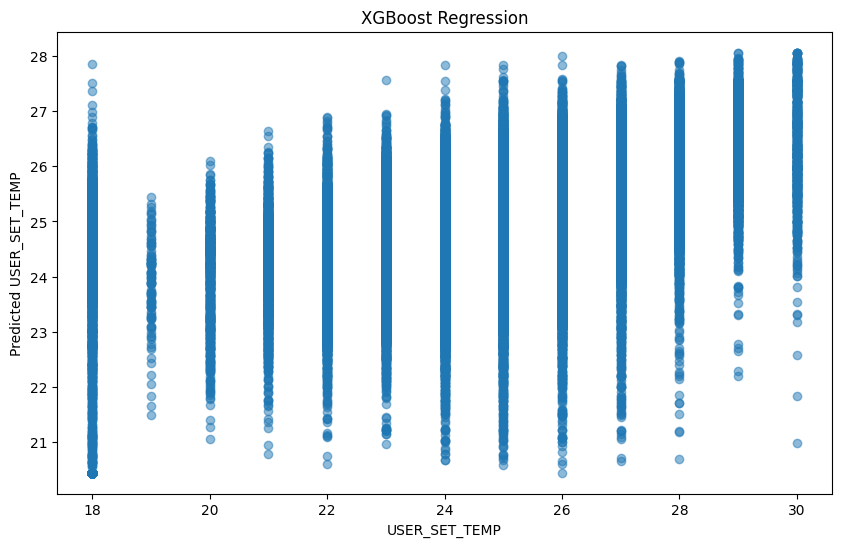

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# XGBoost 데이터 형식인 DMatrix로 변환
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# XGBoost 모델 설정
params = {
    'objective': 'reg:squarederror',  # 회귀 문제 설정
    'max_depth': 100,                    # 트리의 최대 깊이
    'learning_rate': 0.1,              # 학습 속도
    'n_estimators': 100,

}

# XGBoost 모델 훈련
model = xgb.train(params, dtrain, num_boost_round=10)

# 테스트 세트 예측
y_pred = model.predict(dtest)

# 평균 제곱 오차(Mean Squared Error) 출력
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# R2 값 출력
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("USER_SET_TEMP")
plt.ylabel("Predicted USER_SET_TEMP")
plt.title("XGBoost Regression")
plt.show()

pred_xg = y_pred

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error

m_rf = RandomForestClassifier(n_estimators=100, max_depth=200,random_state=1)
m_rf.fit(x_train,y_train)

pred_rf = m_rf.predict(x_test)

print(round(accuracy_score(y_test,pred_rf),4))
print(classification_report(y_test, pred_rf))

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# MAE, MSE, R2 출력
mae = mean_absolute_error(y_test, pred_rf)
mse = mean_squared_error(y_test, pred_rf)
r2 = r2_score(y_test, pred_rf)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

0.4573
              precision    recall  f1-score   support

          18       0.92      0.81      0.86      8075
          19       0.00      0.00      0.00       110
          20       0.35      0.02      0.04       644
          21       0.25      0.02      0.04      1254
          22       0.31      0.10      0.15      3913
          23       0.29      0.13      0.18      7955
          24       0.34      0.32      0.33     17575
          25       0.39      0.50      0.44     28398
          26       0.47      0.57      0.52     33073
          27       0.51      0.51      0.51     21454
          28       0.48      0.35      0.41      8202
          29       0.44      0.20      0.28      2017
          30       0.42      0.08      0.13       685

    accuracy                           0.46    133355
   macro avg       0.40      0.28      0.30    133355
weighted avg       0.45      0.46      0.44    133355

Mean Absolute Error (MAE): 0.9344156574556635
Mean Squared Error (MSE): 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 각 특성의 중요도 출력
feature_importances = m_rf.feature_importances_
print("Feature Importances:")
for feature, importance in zip(x.columns, feature_importances):
    print(f"{feature}: {importance}")

Feature Importances:
CURRENT_ROOM_TEMPERATURE: 0.0915519832110286
p1: 0.12859843697503556
p2: 0.1278553131935283
p10: 0.14444669497919865
E: 0.09848948374375173
F: 0.1715868712464917
G: 0.16168009518594229
H: 0.010911622975517598
I: 0.011814943888671419
J: 0.05306455460083417


## Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline

# 다항 회귀의 차수
degree = 3

# Polynomial Regression 모델 초기화
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# 모델 훈련
poly_model.fit(x_train, y_train)

# 예측
pred_pr = poly_model.predict(x_test)

# R-squared 및 MSE 계산
r_squared = r2_score(y_test, pred_pr)
mse = mean_squared_error(y_test, pred_pr)

# Adjusted R-squared 계산
n = len(y_test)
k = x_test.shape[1]
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))


print(f'R-squared: {r_squared:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Adjusted R-squared: {adjusted_r_squared:.2f}')

In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score

#XGBoost 회귀 모델 초기화 및 훈련
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.2, max_depth=100, objective="reg:squarederror", alpha=0.01, random_state=42)
xgb_model.fit(x_train, y_train)

# 훈련된 모델을 사용하여 예측
pred_xg = xgb_model.predict(x_test)

# 성능 평가
mse = mean_squared_error(y_test, pred_xg)
r2 = r2_score(y_test, pred_xg)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared (R2) Score: {r2:.2f}')

Mean Squared Error: 2.29
R-squared (R2) Score: 0.60


## DNN

In [ ]:
x_stack = np.column_stack((pred_rf, pred_gb, pred_xg, pred_la))
x_stack.shape

(133355, 4)

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# 데이터 정규화 (예: StandardScaler 사용)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# 모델 요약
model.summary()

# 모델 훈련
model.fit(x_train_scaled, y_train, epochs=5, batch_size=2, validation_data=(x_test_scaled, y_test))


# 1단계 모델 예측을 사용한 2단계 모델 예측
pred = model.predict(x_test_scaled)

r2 = r2_score(y_test, pred)
print(f"R2 Score: {r2}")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                1984      
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4097 (16.00 KB)
Trainable params: 4097 (16.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
200032/200032 [==============================] - 690s 3ms/step - loss: 2.8642 - mse: 2.8642 - val_loss: 2.3455 - val_mse: 2.3455
Epoch 2/5
200032/200032 [==============================] - 672s 3ms/step - loss: 2.2620 - mse: 2.2620 - val_loss: 2.3995 - val_mse: 2.3995
Epoch 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# MAE, MSE, R2 출력
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# ~~~4) Other approach - KMeans clustering~~~

<Axes: xlabel='USER_SET_TEMPERATURE', ylabel='Density'>

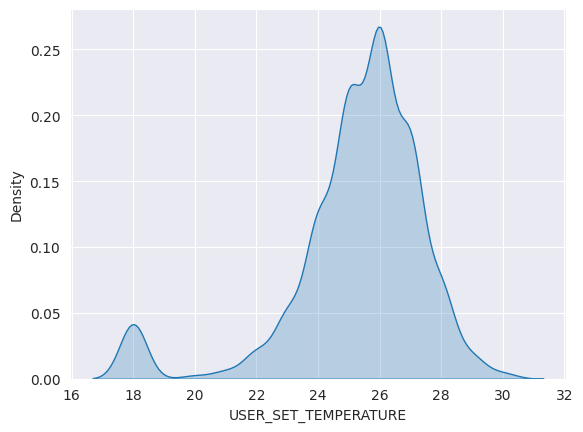

In [ ]:
import seaborn
seaborn.set_style("darkgrid")
seaborn.kdeplot(y, fill=True, bw_method=.2)
# seaborn.boxplot(x=y)

In [ ]:
x = rem[['C','CURRENT_ROOM_TEMPERATURE', 'USER_SET_TEMPERATURE']]
x = pd.get_dummies(x)
x = x[['C_P','CURRENT_ROOM_TEMPERATURE', 'USER_SET_TEMPERATURE']]

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 3, max_iter=1000)
km.fit(x)

x['cluster'] = km.fit_predict(x)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


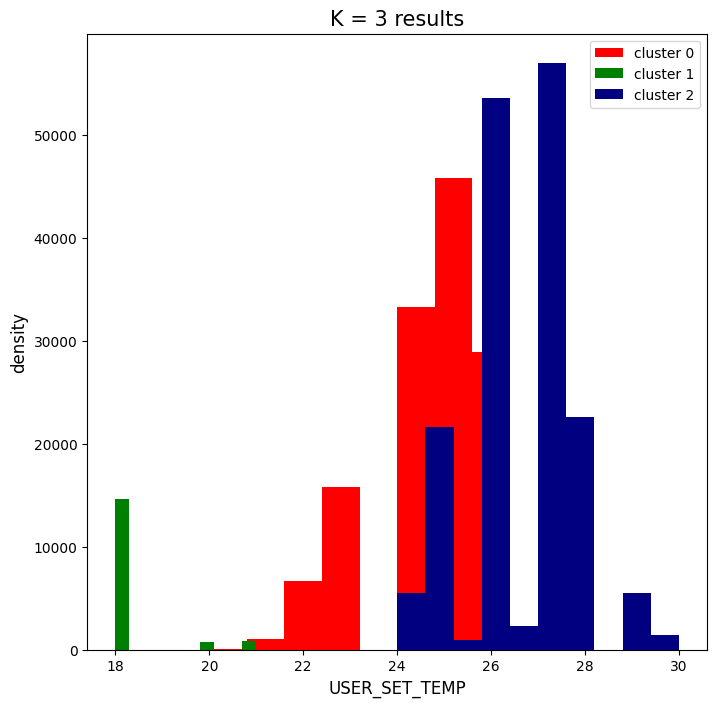

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

k=3
colors = ['red','orange','yellow','green','skyblue','navy','purple', 'pink', 'grey','magenta','lime']
colors2 = ['red', 'green', 'navy']
for i in range(k):
    plt.hist(x.loc[x['cluster'] == i, 'USER_SET_TEMPERATURE'],
                label = 'cluster ' + str(i),color=colors2[i])
plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('USER_SET_TEMP', size = 12)
plt.ylabel('density', size = 12)
plt.show()

In [ ]:
cluster0 = x[x['cluster']==0]
cluster1 = x[x['cluster']==1]
cluster2 = x[x['cluster']==2]

In [ ]:
print(cluster0.shape)
print(cluster1.shape)
print(cluster2.shape)

(133303, 4)
(16182, 4)
(170556, 4)


In [ ]:
from sklearn.model_selection import train_test_split

x0 = cluster0.drop(labels='USER_SET_TEMPERATURE', axis=1)
y0 = cluster0['USER_SET_TEMPERATURE']

x1 = cluster1.drop(labels='USER_SET_TEMPERATURE', axis=1)
y1 = cluster1['USER_SET_TEMPERATURE']

x2 = cluster2.drop(labels='USER_SET_TEMPERATURE', axis=1)
y2 = cluster2['USER_SET_TEMPERATURE']

x0_train,x0_test,y0_train,y0_test = train_test_split(x0,y0, random_state=0)
x1_train,x1_test,y1_train,y1_test = train_test_split(x1,y1, random_state=0)
x2_train,x2_test,y2_train,y2_test = train_test_split(x2,y2, random_state=0)

## C0

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

m_rf = RandomForestClassifier(n_estimators=100, max_depth=200,random_state=1)
y0_train2 = y0_train*2
m_rf.fit(x0_train,y0_train2)

pred0 = m_rf.predict(x0_test)
y0_test2 = y0_test*2
print(round(accuracy_score(y0_test2,pred0),4))

from sklearn.metrics import classification_report
print(classification_report(y0_test2, pred0))

0.4688
              precision    recall  f1-score   support

        40.0       0.00      0.00      0.00        32
        42.0       0.00      0.00      0.00       271
        44.0       0.00      0.00      0.00      1652
        46.0       1.00      0.11      0.19      3936
        48.0       0.45      0.27      0.34      8076
        49.0       0.00      0.00      0.00       207
        50.0       0.46      0.67      0.55     11256
        51.0       0.00      0.00      0.00       256
        52.0       0.47      0.76      0.58      7255
        53.0       0.00      0.00      0.00        28
        54.0       0.00      0.00      0.00       343
        56.0       0.00      0.00      0.00        14

    accuracy                           0.47     33326
   macro avg       0.20      0.15      0.14     33326
weighted avg       0.48      0.47      0.41     33326



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## C1

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

m_rf = RandomForestClassifier(n_estimators=100, max_depth=200,random_state=0)
y1_train2 = y1_train*2
m_rf.fit(x1_train,y1_train2)

pred1 = m_rf.predict(x1_test)
y1_test2 = y1_test*2
print(round(accuracy_score(y1_test2,pred1),4))

from sklearn.metrics import classification_report
print(classification_report(y1_test2, pred1))

0.9259
              precision    recall  f1-score   support

        36.0       0.98      0.95      0.96      3695
        40.0       0.58      0.81      0.67       160
        42.0       0.47      0.62      0.54       191

    accuracy                           0.93      4046
   macro avg       0.68      0.79      0.72      4046
weighted avg       0.94      0.93      0.93      4046



## C2

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

m_rf = RandomForestClassifier(n_estimators=100, max_depth=200,random_state=0)
y2_train2 = y2_train*2
m_rf.fit(x2_train,y2_train2)

pred2 = m_rf.predict(x2_test)
y2_test2 = y2_test*2
print(round(accuracy_score(y2_test2,pred2),4))

from sklearn.metrics import classification_report
print(classification_report(y2_test2, pred2))

0.3954
              precision    recall  f1-score   support

        48.0       0.00      0.00      0.00      1399
        49.0       0.00      0.00      0.00        33
        50.0       0.00      0.00      0.00      5370
        51.0       0.00      0.00      0.00       245
        52.0       0.38      0.66      0.48     13275
        53.0       0.00      0.00      0.00       561
        54.0       0.44      0.55      0.49     14115
        55.0       0.00      0.00      0.00       255
        56.0       0.21      0.07      0.10      5631
        58.0       0.00      0.00      0.00      1393
        60.0       0.00      0.00      0.00       362

    accuracy                           0.40     42639
   macro avg       0.09      0.12      0.10     42639
weighted avg       0.29      0.40      0.32     42639



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ~~~DNN - categorical approach~~~

In [ ]:
x.shape

(320041, 12)

In [ ]:
len(y.unique())

12

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# model = tf.keras.models.Sequential([

#   tf.keras.layers.Dense(10, activation='softmax')
# ])

# 데이터 정규화 (예: StandardScaler 사용)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 레이블 인코딩 및 원-핫 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_one_hot = to_categorical(y_train_encoded, num_classes=12)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=12)

# TensorFlow DNN 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(12,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_scaled, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)

# 테스트 데이터에 대한 예측
y_pred_prob = model.predict(x_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# 정확도 평가
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Epoch 1/10
6001/6001 [==============================] - 60s 9ms/step - loss: 1.5107 - accuracy: 0.4338 - val_loss: 1.4558 - val_accuracy: 0.4625
Epoch 2/10
6001/6001 [==============================] - 44s 7ms/step - loss: 1.4412 - accuracy: 0.4665 - val_loss: 1.4250 - val_accuracy: 0.4716
Epoch 3/10
6001/6001 [==============================] - 45s 8ms/step - loss: 1.4253 - accuracy: 0.4734 - val_loss: 1.4104 - val_accuracy: 0.4804
Epoch 4/10
6001/6001 [==============================] - 46s 8ms/step - loss: 1.4161 - accuracy: 0.4766 - val_loss: 1.4079 - val_accuracy: 0.4795
Epoch 5/10
6001/6001 [==============================] - 44s 7ms/step - loss: 1.4106 - accuracy: 0.4787 - val_loss: 1.4119 - val_accuracy: 0.4777
Epoch 6/10
6001/6001 [==============================] - 45s 7ms/step - loss: 1.4057 - accuracy: 0.4803 - val_loss: 1.4081 - val_accuracy: 0.4791
Epoch 7/10
6001/6001 [==============================] - 45s 7ms/step - loss: 1.4026 - accuracy: 0.4827 - val_loss: 1.4016 - val_ac